In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [2]:
# Import the required libraries
from fastai import *
from fastai.text import *
import pandas as pd

In [3]:
# Load the data
path = "/kaggle/input/nlp-getting-started/"
train = pd.read_csv(f'{path}train.csv')
test = pd.read_csv(f'{path}test.csv')

## EDA

In [4]:
train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

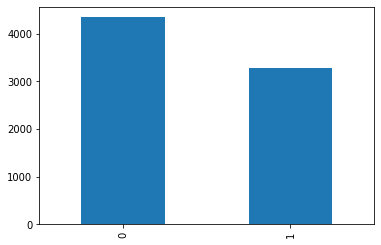

In [9]:
train['target'].value_counts().plot(kind='bar')

In [10]:
train[train['target']== 1][['text','target']]

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [11]:
train[train['target']== 0][['text','target']]

,text,target
15,What's up man?,0
16,I love fruits,0
17,Summer is lovely,0
18,My car is so fast,0
19,What a goooooooaaaaaal!!!!!!,0
...,...,...
7581,@engineshed Great atmosphere at the British Li...,0
7582,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,These boxes are ready to explode! Exploding Ki...,0
7587,Sirens everywhere!,0


In [12]:
# Drop the columns that are not needed for analysis
train.drop(['id','keyword','location'],axis = 1,inplace=True)
train.head()


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
test.drop(['id','keyword','location'],axis = 1,inplace=True)
test.head()
test['target'] = 0
test.head()

,text,target
0,Just happened a terrible car crash,0
1,"Heard about #earthquake is different cities, s...",0
2,"there is a forest fire at spot pond, geese are...",0
3,Apocalypse lighting. #Spokane #wildfires,0
4,Typhoon Soudelor kills 28 in China and Taiwan,0


In [14]:
# Separate the Training and Validation datasets
valid_x = np.random.choice(np.arange(len(train)),round(len(train)*0.2),replace=False)
print(valid_x.shape[0])
train_x = np.asarray(list(set(np.arange(len(train)))-set(valid_x)))
print(train_x.shape[0])
assert(train.shape[0] == train_x.shape[0]+valid_x.shape[0])

1523
6090


In [15]:
# Set a small batch size
bs = 32

In [16]:
df_tr = train.iloc[train_x,[1,0]]
df_val = train.iloc[valid_x,[1,0]]
df_te = test.iloc[:,[1,0]]

df_tr.head()
df_val.head()
df_te.head()

,target,text
0,0,Just happened a terrible car crash
1,0,"Heard about #earthquake is different cities, s..."
2,0,"there is a forest fire at spot pond, geese are..."
3,0,Apocalypse lighting. #Spokane #wildfires
4,0,Typhoon Soudelor kills 28 in China and Taiwan


In [17]:
# Create a learning model and a classifier using the Fastai library
data_lm = TextLMDataBunch.from_df(path,train_df = df_tr,valid_df = df_val)

data_class = TextClasDataBunch.from_df(path,train_df = df_tr,valid_df = df_val,vocab=data_lm.train_ds.vocab, bs=bs,test_df = df_te)

In [18]:
data_lm.show_batch()

idx,text
0,i 'm on top of the hill and i can see a fire in the woods ... xxbos xxmaj there 's an emergency evacuation happening now in the building across the street xxbos i 'm afraid that the tornado is coming to our area ... xxbos xxmaj three people died from the heat wave so far xxbos xxmaj haha xxmaj south xxmaj tampa is getting flooded xxunk xxup wait a
1,xxbos xxmaj anyone need a p / u tonight ? i play xxmaj hybrid xxmaj slayer xxunk xxup eu . xxup xxunk xxunk xxunk xxunk xxup xxunk xxup xxunk xxunk xxbos xxmaj experts in xxmaj france begin examining airplane debris found on xxmaj reunion xxmaj island : xxmaj french air accident experts o ... http : / / t.co / xxunk # news xxbos xxmaj strict liability in the context
2,die ! xxmaj please xxup rt & & sign petition ! xxmaj take a stand & & be a voice for them ! # gilbert23 https : / / t.co / e8dl1lncvu xxbos xxmaj stop the xxmaj annihilation of the xxmaj salt xxmaj river xxmaj wild xxmaj horses ! http : / / t.co / xxunk via @change xxbos xxunk and he 's the current xxmaj xxunk in the xxunk
3,xxmaj satan - http : / / t.co / xxunk xxbos xxup wwi xxup wwii xxup japanese xxup army xxup navy xxup military xxup japan xxup leather xxup watch xxup war xxup mido xxup ww1 2 - xxmaj full read by ebay http : / / t.co / xxunk http : / / t.co / xxunk xxbos xxmaj beyonce xxmaj is my pick for http : / / t.co /
4,/ t.co / xxunk xxbos xxup ik xxmaj only xxmaj troll xxmaj his xxmaj pol xxmaj xxunk xxmaj never xxmaj literally xxmaj abused xxmaj them xxmaj or xxmaj attacked xxmaj their xxmaj families . xxmaj while xxmaj all xxmaj of xxmaj them xxmaj literally xxmaj abuse xxup ik . xxmaj xxunk xxbos xxmaj christian xxmaj attacked by xxmaj muslims at the xxmaj temple xxmaj mount after xxmaj waving xxmaj israeli


In [19]:
# Path for storing output
opath = '/kaggle/working/'
data_lm.save('/kaggle/working/data_lm_export.pkl')
data_class.save('/kaggle/working/data_class_export.pkl')

In [20]:
data_lm = load_data('/kaggle/working/','data_lm_export.pkl')
data_class = load_data('/kaggle/working/','data_class_export.pkl')

In [21]:
# Build the learning model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, path = opath)

In [22]:
x,y = next(iter(data_lm.train_dl))
example = x[:15,:15].cpu()
texts = pd.DataFrame([data_lm.train_ds.vocab.textify(l).split(' ') for l in example])
texts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,i,'m,on,top,of,the,hill,and,i,can,see,a,fire,in,the
1,xxbos,xxmaj,anyone,need,a,p,/,u,tonight,?,i,play,xxmaj,hybrid,xxmaj
2,die,!,xxmaj,please,xxup,rt,&,&,sign,petition,!,xxmaj,take,a,stand
3,xxmaj,satan,-,http,:,/,/,t.co,/,xxunk,xxbos,xxup,wwi,xxup,wwii
4,/,t.co,/,xxunk,xxbos,xxup,ik,xxmaj,only,xxmaj,troll,xxmaj,his,xxmaj,pol
5,xxunk,in,the,fight,against,infectious,xxunk,and,bioterrorism,/,xxup,û,_,http,:
6,xxrep,4,?,love,her,?,?,xxbos,xxmaj,xxunk,going,90,-,100,.
7,on,...,http,:,/,/,t.co,/,xxunk,xxbos,xxunk,xxunk,xxmaj,mega,bloody
8,to,xxmaj,drake,body,bagging,xxmaj,meek,again,!,!,xxmaj,meek,u,ca,n't
9,pilots,on,the,xxmaj,hiroshima,bombing,mission,http,:,/,/,t.co,/,xxunk,xxbos


In [23]:
# Set the GPU
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.set_device(0)

In [24]:
#Create a learner object that will directly create a model, download the pre-trained weights and perform fine-tuning

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.563153,3.724750,0.383408,00:05


In [25]:
# Predict the context
learn.predict("there is", n_words=10)

'there is another British film that features humanity . Sometimes'

In [26]:
learn.predict("you are", n_words=10)

'you are the Second Blue Globe Company'

In [27]:
# save the encoder
learn.save_encoder('ft_enc')

In [28]:
# Building the classifer
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6090 items)
x: TextList
xxbos xxmaj forest fire near xxmaj la xxmaj xxunk xxmaj xxunk . xxmaj canada,xxbos xxunk people receive # wildfires evacuation orders in xxmaj california,xxbos xxmaj just got sent this photo from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school,xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj xxunk xxunk xxmaj colorado xxmaj springs areas,xxbos i 'm on top of the hill and i can see a fire in the woods ...
y: CategoryList
1,1,1,1,1
Path: /kaggle/input/nlp-getting-started;

Valid: LabelList (1523 items)
x: TextList
xxbos xxmaj tennessee xxunk couple xxunk hate crime and destroyed own home with xxunk _ http : / / t.co / xxunk # xxmaj xxunk,xxbos xxmaj the xxmaj guardian view on the xxmaj hiroshima legacy : still in the shadow of the bomb | xxmaj xxunk : xxmaj the world longs to xxunk ... http : / / t.co / xxunk,xxbos # xxmaj kick xxmaj xxunk xxup xxunk |

In [29]:
data_class.show_batch()


text,target
xxbos _ \n xxrep 5 ? xxup retweet \n xxrep 7 ? \n xxrep 5 ? xxup follow xxup all xxup who xxup rt \n xxrep 7 ? \n xxrep 5 ? xxup followback \n xxrep 7 ? \n xxrep 5 ? xxup gain xxup with \n xxrep 7 ? \n xxrep 5 ? xxup follow ? xxunk # xxup xxunk,0
xxbos xxup info xxup s. xxup wnd : 030 / 6 . xxup cld : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 .,0
xxbos xxmaj no # news of # hostages in # xxmaj libya \n \n http : / / t.co / xxunk \n \n # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1
xxbos xxmaj no # news of # hostages in # xxmaj libya \n \n http : / / t.co / xxunk \n \n # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,1


In [30]:
# Training the model
learn.fit_one_cycle(1, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,0.559991,0.499415,0.763624,00:05


In [31]:
# Freezing and fine-tuning
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))


epoch,train_loss,valid_loss,accuracy,time
0,0.518340,0.464373,0.803020,00:05


In [32]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.488594,0.449594,0.803020,00:05


In [33]:
# Sample predictions for disaster tweets
learn.predict("Assistance from across Canada and as far away as Mexico have joined #ForestFire fighting efforts in the #Northeast Region. Mexican fire crews arrived at Sudbury July 20, and are deployed to fires around the region. #Ontario")

(Category 1, tensor(1), tensor([0.0666, 0.9334]))

In [34]:
learn.predict("Interpreters needed to support rescue efforts in México. #EarthquakeMexico")

(Category 1, tensor(1), tensor([0.3525, 0.6475]))

In [35]:
learn.predict('Oaxaca, Mexico: A new 6.1-magnitude quake has shaken southern Mexico #EarthquakeMexico #Oaxaca \\ Circa \\')

(Category 1, tensor(1), tensor([0.3530, 0.6470]))

In [36]:
learn.predict('the best thing I’ve ever done, my greatest role in this life #HappyMothersDay')

(Category 0, tensor(0), tensor([0.9871, 0.0129]))

In [37]:
learn.predict('Can you please help me share this message for my mom ? Thanks a lot 🙏')

(Category 0, tensor(0), tensor([0.9618, 0.0382]))

In [38]:
learn.predict("I'm just trying to take care of her, do my job and be the best Jet I can be. @RetireMoms | #HappyMothersDay")

(Category 0, tensor(0), tensor([0.9689, 0.0311]))

In [39]:
valid_probs,valid_y = learn.get_preds(ds_type= DatasetType.Valid,ordered = True)

In [40]:
valid_probs.numpy()


array([[0.367857, 0.632143],
       [0.483867, 0.516133],
       [0.70733 , 0.29267 ],
       [0.984172, 0.015828],
       ...,
       [0.735861, 0.264139],
       [0.513805, 0.486195],
       [0.800371, 0.199629],
       [0.780678, 0.219322]], dtype=float32)

In [41]:
valid_preds = np.argmax(valid_probs.numpy(),1)


In [42]:
np.unique(valid_preds,return_counts=True)


(array([0, 1]), array([1013,  510]))

In [43]:
# Validation accuracy
from sklearn.metrics import *
accuracy_score(valid_y,valid_preds)

0.8030203545633617

In [44]:
learn

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6090 items)
x: TextList
xxbos xxmaj forest fire near xxmaj la xxmaj xxunk xxmaj xxunk . xxmaj canada,xxbos xxunk people receive # wildfires evacuation orders in xxmaj california,xxbos xxmaj just got sent this photo from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school,xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj xxunk xxunk xxmaj colorado xxmaj springs areas,xxbos i 'm on top of the hill and i can see a fire in the woods ...
y: CategoryList
1,1,1,1,1
Path: /kaggle/input/nlp-getting-started;

Valid: LabelList (1523 items)
x: TextList
xxbos xxmaj tennessee xxunk couple xxunk hate crime and destroyed own home with xxunk _ http : / / t.co / xxunk # xxmaj xxunk,xxbos xxmaj the xxmaj guardian view on the xxmaj hiroshima legacy : still in the shadow of the bomb | xxmaj xxunk : xxmaj the world longs to xxunk ... http : / / t.co / xxunk,xxbos # xxmaj kick xxmaj xxunk xxup xxunk |

In [45]:
# Test data accuracy
test_probs,test_y  = learn.get_preds(ds_type = DatasetType.Test,ordered =True)
test_probs.numpy()

array([[0.337031, 0.662969],
       [0.178134, 0.821866],
       [0.046449, 0.953551],
       [0.492347, 0.507653],
       ...,
       [0.246941, 0.753059],
       [0.187572, 0.812428],
       [0.154748, 0.845252],
       [0.551139, 0.448861]], dtype=float32)

In [46]:
test_preds = np.argmax(test_probs.numpy(),1)
np.unique(test_preds,return_counts=True)
from sklearn.metrics import *
accuracy_score(test_y,test_preds)

0.6561446521605884

In [48]:
test_preds = np.argmax(test_probs.numpy(),1)
print(f'{test_preds.sum()} positives in {test_preds.shape[0]}')

1122 positives in 3263


In [59]:
np.unique(test_preds,return_counts=True)

(array([0, 1]), array([2141, 1122]))

In [51]:
sample_submission = pd.read_csv(os.path.join(path,'sample_submission.csv'))

In [52]:
sample_submission['target'] = test_preds
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [53]:
# Output csv file
sample_submission.to_csv('sub_1234.csv',index=False)
